In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [ ]:
df = pd.read_csv('BTC-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


**<h3>ARIMA 7-2-1</h3>**

In [ ]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

                   Close
Date                    
2019-01-01   3843.520020
2019-01-02   3943.409424
2019-01-03   3836.741211
2019-01-04   3857.717529
2019-01-05   3845.194580
...                  ...
2023-03-27  27139.888670
2023-03-28  27268.130860
2023-03-29  28348.441410
2023-03-30  28033.562500
2023-03-31  28478.484380

[1551 rows x 1 columns]


In [ ]:
print(len(df))
print(len(train_data))
print(train_size)

1551
1085
1085


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.5 MB/s eta 0:00:00


In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18326.915, Time=2.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18334.592, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18334.396, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18334.415, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18333.913, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18338.414, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18338.402, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18328.615, Time=5.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18328.727, Time=7.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18336.402, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18339.506, Time=1.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18339.964, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=18338.278, Time=1.89 sec

Best model:  ARIMA(2,1,2

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[47060.44417267 47306.98002779 47400.43473151 47291.38944196
 47143.01338451 47150.91932063 47338.58897684 47541.82894864
 47588.7019632  47478.27760966 47372.84103744 47421.193624
 47604.98856781 47766.32126954 47778.67322624 47676.54524514
 47611.42399726 47688.65137721 47860.51395819 47983.57437329
 47972.36352013 47885.07121031 47855.8285

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('Testing MAE: ', mae)
mae = mean_absolute_error(y_val,y_pred_val)
print('Validation MAE: ', mae)


Testing MAE:  21968.045414250082
Validation MAE:  29486.81970517302


In [ ]:
mse = mean_squared_error(y_test,y_pred)
print('Testing MSE: ', mse)
mse = mean_squared_error(y_val,y_pred_val)
print('Validation MSE: ', mse)

Testing MSE:  656003759.0732521
Validation MSE:  875798845.2854458


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('Testing RMSE: ', rmse)
rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print('Validation RMSE: ', rmse)

Testing RMSE:  25612.570333202642
Validation RMSE:  29593.898784807752


In [ ]:
r2 = r2_score(y_test, y_pred)
print('Testing R-Square:', r2)
r2 = r2_score(y_val, y_pred_val)
print('Validation R-Square: ', r2)

Testing R-Square: -5.326890833285008
Validation R-Square:  -64.14123405382163


In [ ]:
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('Testing MAPE: ', mape)
mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))
print('Validation MAPE: ', mape)



Testing MAPE:  0.9374604237736818
Validation MAPE:  1.4947639255436262


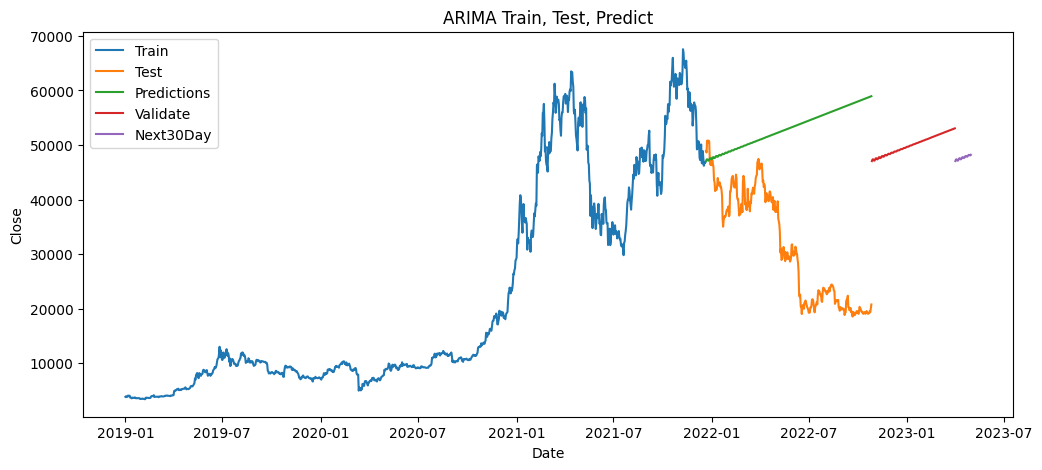

In [ ]:
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()